# Abdullah Alhussni - aa10108
## Applied Machine Learning - ENGR-UH 3332 - DL Project 1

In [2]:
from __future__ import division

import warnings
from collections import namedtuple
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
from torch import Tensor
import torch.optim as optim
import os
import numpy as np
import os.path
from glob import glob
from PIL import Image
from tqdm import tqdm
import torchvision.datasets as dset
import torch.utils.data as data
from ipywidgets import IntProgress
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else: 
    device = 'cpu'

print(device)

cuda


In [6]:
learning_rate = 0.01
trainBatchSize = 20
testBatchSize = 20
num_epochs = 50

os.makedirs("../data", exist_ok = True)

In [7]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# Data Loader

In [8]:
train_set = dset.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=trainBatchSize, shuffle=True)
test_set = dset.CIFAR10(root='../data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=testBatchSize, shuffle=False)

100%|██████████| 170M/170M [01:50<00:00, 1.54MB/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


# Inception

In [6]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size = 1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size = 1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 max pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_planes, pool_planes, kernel_size = 1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim = 1)

# GoogLeNet

In [7]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
        
        self.num_classes = num_classes

        self.first = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 192, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        # Inception Modules
        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride = 2, padding = 1)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flat = nn.Linear(1024, self.num_classes)

    def forward(self, x):
        x = self.first(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.flat(x)

        return x

# The model

In [8]:
model = GoogLeNet(num_classes = 10).to(device)

In [9]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)

# Training function
## Returns loss and accuracy

In [10]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    avg_loss = train_loss / len(train_loader)
    print(f'Train Loss: {avg_loss:.3f}, Accuracy: {acc:.2f}%')
    return avg_loss

# Testing function
## Returns loss and accuracy

In [11]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.3f}, Accuracy: {acc:.2f}%')
    return avg_loss

Epoch 1/50
Train Loss: 1.580, Accuracy: 40.80%
Test Loss: 1.149, Accuracy: 59.02%
Epoch 2/50
Train Loss: 0.986, Accuracy: 65.18%
Test Loss: 0.810, Accuracy: 71.26%
Epoch 3/50
Train Loss: 0.750, Accuracy: 74.17%
Test Loss: 0.676, Accuracy: 76.22%
Epoch 4/50
Train Loss: 0.636, Accuracy: 78.06%
Test Loss: 0.614, Accuracy: 78.76%
Epoch 5/50
Train Loss: 0.553, Accuracy: 81.04%
Test Loss: 0.652, Accuracy: 77.73%
Epoch 6/50
Train Loss: 0.494, Accuracy: 83.05%
Test Loss: 0.515, Accuracy: 82.51%
Epoch 7/50
Train Loss: 0.445, Accuracy: 84.43%
Test Loss: 0.497, Accuracy: 83.30%
Epoch 8/50
Train Loss: 0.399, Accuracy: 86.22%
Test Loss: 0.455, Accuracy: 84.18%
Epoch 9/50
Train Loss: 0.364, Accuracy: 87.44%
Test Loss: 0.467, Accuracy: 83.95%
Epoch 10/50
Train Loss: 0.333, Accuracy: 88.46%
Test Loss: 0.441, Accuracy: 84.66%
Epoch 11/50
Train Loss: 0.306, Accuracy: 89.28%
Test Loss: 0.429, Accuracy: 86.07%
Epoch 12/50
Train Loss: 0.278, Accuracy: 90.34%
Test Loss: 0.468, Accuracy: 85.61%
Epoch 13/50
T

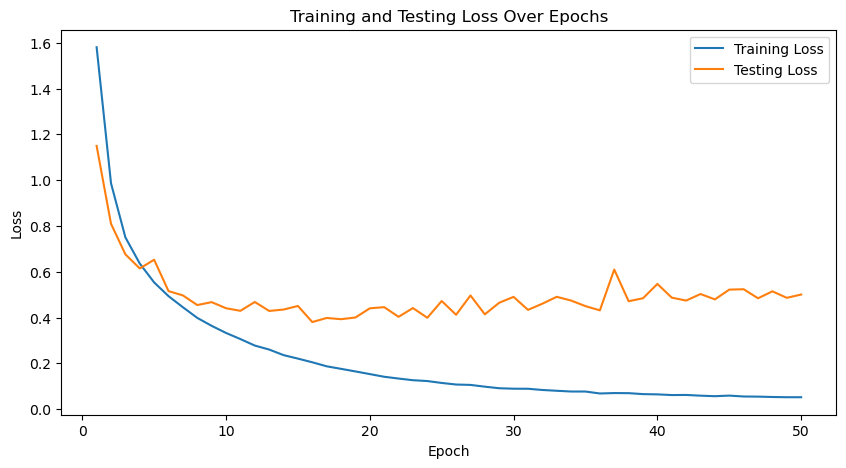

In [ ]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    scheduler.step()

torch.save(model.state_dict(), "../data/projDL1/cifar10_googlenet.pth")

plt.figure(figsize = (10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label = 'Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label = 'Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()